# Twitter Sentiment Analysis

### Importing necessary Libraries

In [285]:
import re
import nltk
import string
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from nltk.corpus import twitter_samples, stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

In [3]:
nltk.download('twitter_samples')
nltk.download('stopwords')

[nltk_data] Downloading package twitter_samples to C:\Users\Sodiq Agba
[nltk_data]     ML\AppData\Roaming\nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Sodiq Agba
[nltk_data]     ML\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Importing Dataset

In [13]:
positive_tweets = twitter_samples.strings('positive_tweets.json')
negative_tweets = twitter_samples.strings('negative_tweets.json')

In [14]:
positive_tweets[1], negative_tweets[1]

('@Lamb2ja Hey James! How odd :/ Please call our Contact Centre on 02392441234 and we will be able to assist you :) Many thanks!',
 "Everything in the kids section of IKEA is so cute. Shame I'm nearly 19 in 2 months :(")

In [16]:
len(positive_tweets), len(negative_tweets)

(5000, 5000)

### Dataframe

In [164]:
positive_df = pd.DataFrame({'Tweets': positive_tweets, 'Sentiment' : np.ones(len(positive_tweets))})
negative_df = pd.DataFrame({'Tweets': negative_tweets, 'Sentiment': np.zeros(len(positive_tweets))})

tweets_df = pd.concat([positive_df, negative_df], axis = 0).sample(n = 10000).reset_index(drop = True)

In [166]:
tweets_df.head()

,Tweets,Sentiment
0,@syukribinahmad have fun besok.. :),1.0
1,@_stroya nou youre not :-( here have a picture...,0.0
2,Expired and I used BIS money now I'm broke ):(...,0.0
3,Add me on Snapchat - MaryHicks18 #snapchat #ki...,1.0
4,@Gurmeetramrahim #OurDaughtersOurPride #mypapa...,1.0


In [169]:
tweets_df['Sentiment'].value_counts(normalize = True)

1.0    0.5
0.0    0.5
Name: Sentiment, dtype: float64

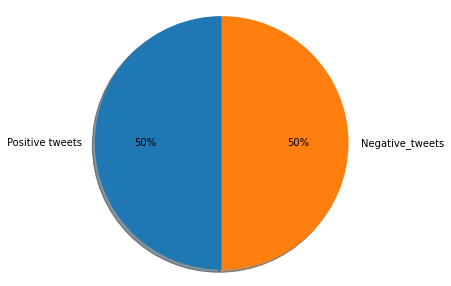

In [279]:
fig = plt.figure(figsize = (5,5))

labels = 'Positive tweets', 'Negative_tweets'

X = [len(positive_tweets), len(negative_tweets)]

plt.pie(x = X , labels = labels, startangle=90, shadow = True, autopct='%1.0f%%')

plt.axis('equal')

plt.show()

# Data Preprocessing Functions

### Tweet cleaning

In [94]:
def tweet_cleaning(tweet):
    ### Removing Hyper links
    new_tweet = re.sub(r'https?://.[.]\w{2}[/]\w+', '', tweet)
    ### Removing @ sign
    new_tweet = re.sub(r'@', '', new_tweet)
    ### Removing Hash tag
    new_tweet = re.sub(r'#', '', new_tweet)
    return new_tweet

### Tokenization

In [118]:
def tweet_tokenizer(tweet):
    tokenizer = TweetTokenizer(preserve_case= False, reduce_len=False, strip_handles=False)
    return tokenizer.tokenize(tweet)

### Stemming

In [132]:
def tweet_stemmer(word_list):
    stemmer = PorterStemmer()
    stemmed_word = []
    for word in word_list:
        stemmed_word.append(stemmer.stem(word))
    return stemmed_word

### Removing stopwords and Punctuation

In [127]:
def token_clean(token):
    punctuations = string.punctuation
    stop_words = stopwords.words('english')
    new_token = [word for word in token if word not in punctuations if word not in stop_words]
    return new_token

### Single Clean Function

In [134]:
def tweet_to_token(tweet):
    cleaned_tweet = tweet_cleaning(tweet)
    token = tweet_tokenizer(cleaned_tweet)
    token_stem = tweet_stemmer(token)
    final_token = token_clean(token_stem)
    
    return final_token

### Bag of words

In [221]:
def Bag_of_words(tweet_token):
    BOW = []
    for token in tweet_token:
        for word in token:
            BOW.append(word)
    return BOW

### Weight dictionary

In [231]:
def word_weight_dict(BOW, bow):
    word_dict = {}
    for x in BOW:
        word_dict[x] = 0
        for y in bow:
            if x == y:
                word_dict[x] += 1
            else:
                word_dict[x] += 0
    return word_dict

## Applying Cleaning Functions

In [174]:
tweets_df['Token'] = tweets_df['Tweets'].apply(tweet_to_token)

In [222]:
bow = Bag_of_words(tweets_df['Token'])
bow = pd.Series(bow).unique()

### Words dictionary

In [228]:
positive_bow = Bag_of_words(tweets_df['Token'][tweets_df['Sentiment'].eq(1)])#Positive sentiment words
negative_bow = Bag_of_words(tweets_df['Token'][tweets_df['Sentiment'].eq(0)])#Negative sentiments words

In [232]:
positive_dict = word_weight_dict(bow, positive_bow)
negative_dict = word_weight_dict(bow, negative_bow)

In [235]:
def positive_weight(tweet_token):
    weight = 0
    for word in tweet_token:
        weight += positive_dict.get(word, 0)
    return weight

def negative_weight(tweet_token):
    weight = 0
    for word in tweet_token:
        weight += negative_dict.get(word, 0)
    return weight

In [241]:
tweets_df['Positive'] = tweets_df['Token'].apply(positive_weight)
tweets_df['Negative'] = tweets_df['Token'].apply(negative_weight)

In [242]:
tweets_df.head()

,Tweets,Sentiment,Token,Positive,Negative
0,@syukribinahmad have fun besok.. :),1.0,"[syukribinahmad, fun, besok, .., :)]",3880,142
1,@_stroya nou youre not :-( here have a picture...,0.0,"[_stroya, nou, :-(, pictur, adam]",13,522
2,Expired and I used BIS money now I'm broke ):(...,0.0,"[expir, use, bi, money, i'm, broke, ):, theact...",318,545
3,Add me on Snapchat - MaryHicks18 #snapchat #ki...,1.0,"[add, snapchat, maryhick, 18, snapchat, kikmeb...",3846,277
4,@Gurmeetramrahim #OurDaughtersOurPride #mypapa...,1.0,"[gurmeetramrahim, ourdaughtersourprid, mypapam...",3719,12


### Dataset Plot

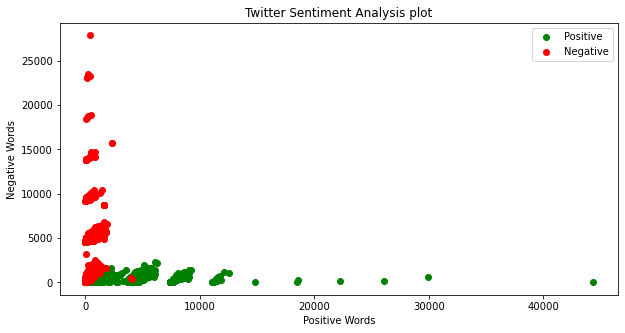

In [266]:
fig = plt.figure(figsize = (10,5))
plt.scatter(tweets_df['Positive'][tweets_df['Sentiment'].eq(1)], tweets_df['Negative'][tweets_df['Sentiment'].eq(1)], label = 'Positive', color = 'green')
plt.scatter(tweets_df['Positive'][tweets_df['Sentiment'].eq(0)], tweets_df['Negative'][tweets_df['Sentiment'].eq(0)], label = 'Negative', color = 'red')

plt.xlabel('Positive Words')
plt.ylabel('Negative Words')

plt.title('Twitter Sentiment Analysis plot')
plt.legend()
plt.show()

## Splitting Dataset

In [244]:
X = tweets_df.drop(['Token','Tweets','Sentiment'], axis = 1)
y = tweets_df['Sentiment']

In [250]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.25, random_state = 2022)

In [252]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7500, 2), (2500, 2), (7500,), (2500,))

### Logistic Regression Model

In [253]:
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)
pred_lr = model_lr.predict(X_test)

In [258]:
test_scores = [accuracy_score(y_test, pred_lr), f1_score(y_test, pred_lr), precision_score(y_test, pred_lr), recall_score(y_test, pred_lr)]
train_scores = [accuracy_score(y_train,model_lr.predict(X_train)), f1_score(y_train, model_lr.predict(X_train)), precision_score(y_train, model_lr.predict(X_train)), recall_score(y_train, model_lr.predict(X_train))]

In [259]:
scores = pd.DataFrame({'Train Scores' : train_scores, 'Test Scores': test_scores}, index = ['Accuracy','F1','Precision','Recall'])
scores

,Train Scores,Test Scores
Accuracy,0.993867,0.996800
F1,0.993872,0.996815
Precision,0.992021,0.995231
Recall,0.995729,0.998405


In [288]:
confusion_matrix(y_test, pred_lr)

array([[1240,    6],
       [   2, 1252]], dtype=int64)

In [287]:
print(classification_report(y_test, pred_lr))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1246
         1.0       1.00      1.00      1.00      1254

    accuracy                           1.00      2500
   macro avg       1.00      1.00      1.00      2500
weighted avg       1.00      1.00      1.00      2500

